In [59]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K
import keras

In [60]:
from keras.datasets import mnist
from keras import backend as K

def mnist_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    Y_train = np_utils.to_categorical(y_train, 10)
    Y_test = np_utils.to_categorical(y_test, 10)
    
    X_train = X_train.reshape([-1, 28, 28, 1])
    X_test  = X_test.reshape([-1, 28, 28, 1])
    return (X_train, Y_train), (X_test, Y_test)

(X_train, y_train), (X_test, y_test) = mnist_data()

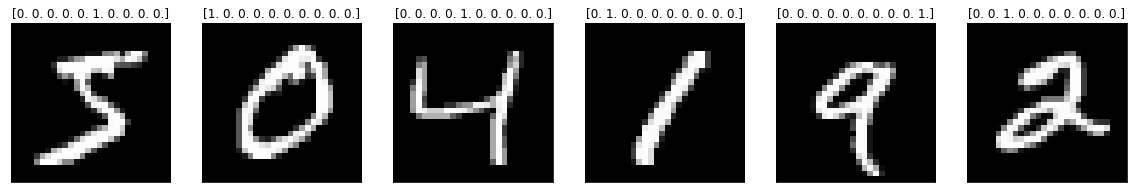

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

In [67]:
# defining the model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


def network():
    model = Sequential()

    model.add(Flatten(input_shape=(28, 28, 1, )))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

In [63]:
def network():
    # define the model
    model = Sequential()
    input_shape = (28, 28, 1)
    num_classes = 10

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    # summarize the model
    #model.summary()
    #keras.utils.plot_model(model, to_file='model.png')
    return model 


In [68]:
model = network()

In [69]:

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])



In [70]:
model.load_weights('model_weights')

ValueError: Layer #1 (named "batch_normalization_3" in the current model) was found to correspond to layer conv2d_17 in the save file. However the new layer batch_normalization_3 expects 4 weights, but the saved weights have 2 elements.

In [71]:
model.fit(X_train, y_train, batch_size=512, epochs=6, verbose=1, validation_data=(X_test, y_test))
model.save_weights('model_weights')

ValueError: Error when checking input: expected flatten_7_input to have 4 dimensions, but got array with shape (60000, 28, 28)

In [72]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Error when checking input: expected flatten_7_input to have 4 dimensions, but got array with shape (10000, 28, 28)

In [73]:
import coremltools
coreml_model = coremltools.converters.keras.convert(
    model, input_names="image", image_input_names='image',
    class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

0 : flatten_7_input, <keras.engine.topology.InputLayer object at 0x124abf860>
1 : flatten_7, <keras.layers.core.Flatten object at 0x124abf908>
2 : dense_14, <keras.layers.core.Dense object at 0x124ac9ef0>
3 : batch_normalization_3, <keras.layers.normalization.BatchNormalization object at 0x124ac9550>
4 : activation_9, <keras.layers.core.Activation object at 0x124ac9588>
5 : dense_15, <keras.layers.core.Dense object at 0x124ac95c0>
6 : batch_normalization_4, <keras.layers.normalization.BatchNormalization object at 0x124b17da0>
7 : activation_10, <keras.layers.core.Activation object at 0x124b4b240>
8 : dense_16, <keras.layers.core.Dense object at 0x124b3f630>
9 : activation_11, <keras.layers.core.Activation object at 0x12743ab70>


In [74]:
coreml_model.author = 'jordan'
coreml_model.license = 'MIT'
coreml_model.short_description = 'MNIST handwriting recognition with a 3 layer network'
coreml_model.input_description['image'] = '28x28 grayscaled pixel values between 0-1'
coreml_model.save('SimpleMnist.mlmodel')

print(coreml_model)

input {
  name: "image"
  shortDescription: "28x28 grayscaled pixel values between 0-1"
  type {
    imageType {
      width: 28
      height: 28
      colorSpace: GRAYSCALE
    }
  }
}
output {
  name: "output1"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "output1"
metadata {
  shortDescription: "MNIST handwriting recognition with a 3 layer network"
  author: "jordan"
  license: "MIT"
}



{'output1': {'0': 0.0, '1': 0.0, '2': 0.0, '3': 1.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0}, 'classLabel': '3'}


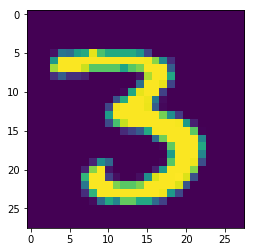

In [19]:
from PIL import Image  
import numpy as np
model =  coremltools.models.MLModel('SimpleMnist.mlmodel')
im = Image.fromarray((np.reshape(mnist_data()[0][0][12]*255, (28, 28))).astype(np.uint8),"L")
#im = Image.fromarray(mnist_data()[0][0][1].reshape(28,28).astype(np.float32), 'L')
plt.imshow(im)
predictions = model.predict({'image': im})
print(predictions)

{'output1': {'0': 0.0, '1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 1.0, '9': 0.0}, 'classLabel': '8'}


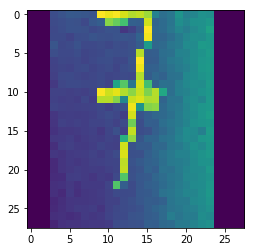

In [26]:

#im = Image.open("IMG_0181.JPG") #5
#im = Image.open("IMG_5349.JPG") #1
#im = Image.open("IMG_9925.JPG") #4
im = Image.open("IMG_4057.JPG") #0
im = Image.open("IMG_9315.JPG") #0

from PIL import ImageEnhance
#im = ImageEnhance.Contrast(im).enhance(2.0)
from PIL import ImageFilter

size = 28, 28
#im.thumbnail(size)
im = im.rotate(-90)
im = im.resize(size)
im = im.convert("L")
#im = im.filter(ImageFilter.MaxFilter(3))
#im.crop((0,0,28,28))
plt.imshow(im)
predictions = model.predict({'image': im})

print(predictions)